In [1]:
import numpy as np
import healpy as hp
from beamconv import ScanStrategy
%matplotlib inline

In [2]:
import qpoint as qp
print(qp.__file__)

/Users/personal/.local/lib/python3.7/site-packages/qpoint/__init__.py


We start by defining our horizon: a 290K source that occupies a little more than half the sky with sinusoidal elevation.

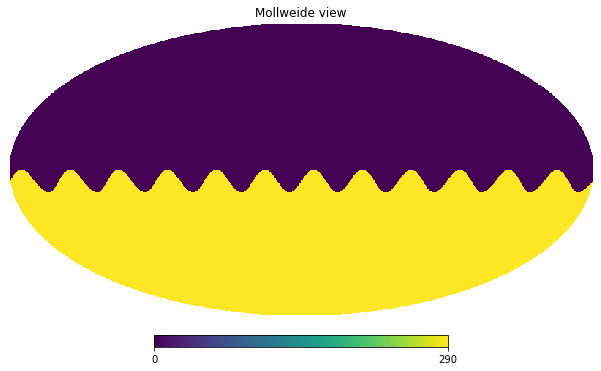

In [3]:
nside = 512
lmax = 700
pixels = np.arange(hp.nside2npix(nside))#all pixels of the healpix map
theta, phi = hp.pix2ang(nside, pixels)#all pixel coordinates 

ground = np.zeros(hp.nside2npix(nside))
ground[theta>(np.pi/2+.1*(np.sin(12*phi)+1))]=290.#horizon condition
alm = hp.map2alm([ground, np.zeros(hp.nside2npix(nside)), np.zeros(hp.nside2npix(nside))], 
                                lmax = lmax)
hp.mollview(ground)

If we look at the auto spectra, there's quite a lot of ringing due to the 'evenness' of the division

Text(0, 0.5, '$D_\\ell^{TT}$ $(K^2)$')

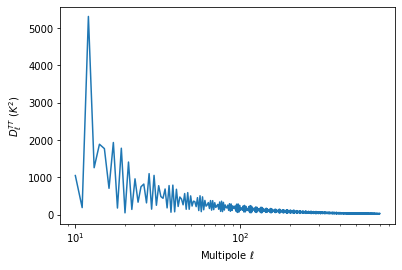

In [4]:
import matplotlib.pyplot as plt

ell = np.arange(lmax+1)
plt.semilogx(ell[10:], ell[10:]*(ell+1)[10:]*hp.anafast(ground, lmax=lmax)[10:]/2/np.pi)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$D_\ell^{TT}$ $(K^2)$')

We also create a beam: it is the sum of two Gaussians, one narrow which is the main beam and one much weaker playing the role of the sidelobes.

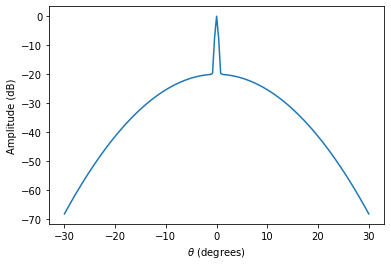

In [5]:
fwhm = np.radians(.5)#main beam, 30 arcmin
side_fwhm = np.radians(15)#sidelobe, 15 degree fwhm!
#1d example
tht = np.linspace(-np.pi/6, np.pi/6, 151)
beam_1d =  0.99*np.exp(-tht**2/(2*(fwhm/2.355)**2))+0.01*np.exp(-tht**2/(2*(side_fwhm/2.355)**2))
plt.plot(tht/np.pi*180., 10*np.log10(beam_1d))
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel('Amplitude (dB)')
#Now the full sky-beam
beam = 0.99*np.exp(-theta**2/(2*(fwhm/2.355)**2))+0.01*np.exp(-theta**2/(2*(side_fwhm/2.355)**2))
rick = hp.map2alm([beam, beam, np.zeros(hp.nside2npix(nside))], lmax=lmax, mmax=lmax)
np.save('./ancillary/gaussian_with_sidelobe', rick, allow_pickle=True)#That's right, Rick turned himself into a pickle. 

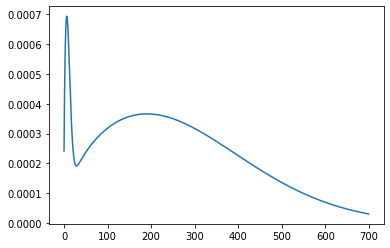

In [6]:
plt.plot(np.real(rick[0, hp.Alm.getidx(700, np.arange(700),0)]))

Now for the proper beamconv part: we define beam options for a single detector, and a scan strategy using our ground_scan keyword.

In [39]:
#Beam options
import pickle
beam_file = './ancillary/beam_opts_ssn.pkl'
beam_opts = dict(az=0,
                 el=0,
                 polang=0.,
                 btype='PO',
                 name='SingleDet',
                 lmax=lmax,
                 mmax=lmax,
                 amplitude=1.,
                 po_file='./ancillary/gaussian_with_sidelobe.npy',
                 deconv_q=True,                       
                 normalize=True)
with open(beam_file, 'wb') as handle:
    pickle.dump(beam_opts, handle, protocol=pickle.HIGHEST_PROTOCOL)

#pointing and scan strat:
ra0        = 0
dec0       = -4
az_throw   = 90
scan_speed = 2.8
rot_period = 4.5*60*60
nside_spin = 512
nsamp=3600*23+56*60
# init scan strategy and instrument
ss = ScanStrategy(nsamp, # mission duration in sec.                                  
                  sample_rate=1, # 100 Hz sample rate                                    
                  location='atacama') # Atacama instrument

ss.load_focal_plane('./ancillary', no_pairs=True)

# Generate timestreams
ss.beams[0][0].btype = 'PO'
ss.scan_instrument_mpi(alm, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=5, binning=False, ground_scan=False)
sky_tod = ss.tod.copy()
sky_pix = ss.pix.copy()
ss.scan_instrument_mpi(alm, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=5, binning=False, ground_scan=True)
ground_tod = ss.tod.copy()
ground_pix = ss.pix.copy()

Scanning with 2 detectors
[rank 000]: working on: SingleDetA, SingleDetB
[rank 000]:	Working on chunk 000: samples 0-86160
(86160, 4)
Scanning with 2 detectors
[rank 000]: working on: SingleDetA, SingleDetB
[rank 000]:	Working on chunk 000: samples 0-86160
(86160, 4)


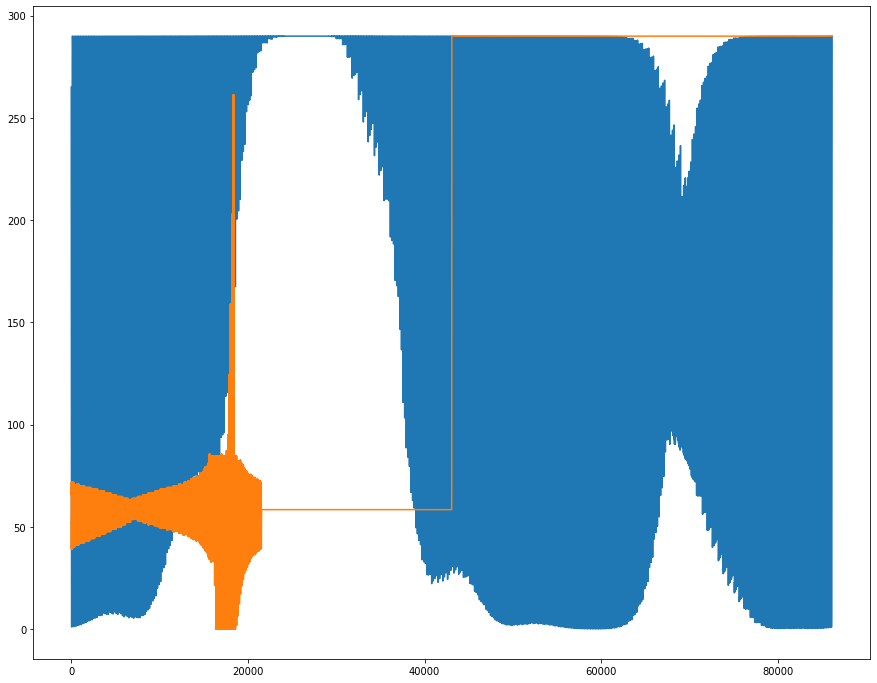

In [40]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(sky_tod)
ax.plot(ground_tod)

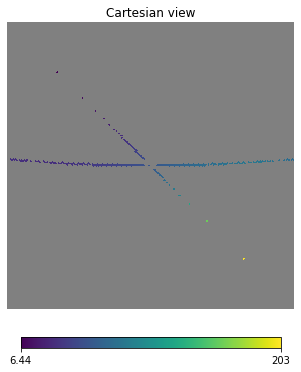

In [41]:
ground_path = np.ones_like(ground)*hp.UNSEEN
ground_path[ground_pix]=ground_tod
hp.cartview(ground_path, lonra=[-10,10], latra=[-10,10])

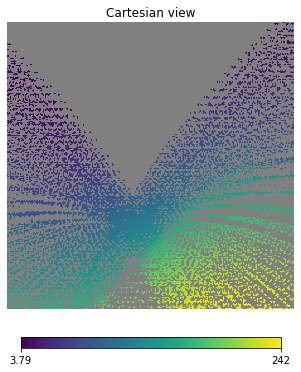

In [42]:
sky_path = np.ones_like(ground)*hp.UNSEEN
sky_path[sky_pix]=sky_tod
hp.cartview(sky_path, lonra=[-10,10], latra=[-10,10])